##**For Image Visualization**

In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/fea.csv')
import numpy as np

pixel_val = data.values
images = pixel_val.reshape(-1, 32, 32)
images = np.array(images)

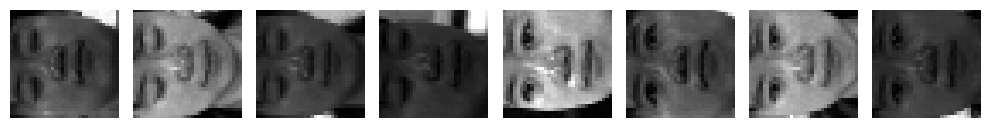

In [ ]:
import matplotlib.pyplot as plt
no_of_pics=8
fig, axes = plt.subplots(1, no_of_pics, figsize=(10, 5))
for i in range(no_of_pics):
    axes[i].imshow(images[i], cmap='gray')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

#**Importing Libaraires**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import time

## **KNN & PCA**

Measured Distances : euclidean, k_value: 19, Number of PCs: 30
Accuracy: 0.13
Computation Time used: 0.13546442985534668

Measured Distances : euclidean, k_value: 19, Number of PCs: 65
Accuracy: 0.13
Computation Time used: 0.15091729164123535

Measured Distances : euclidean, k_value: 19, Number of PCs: 100
Accuracy: 0.13
Computation Time used: 0.15795230865478516

Measured Distances : euclidean, k_value: 155, Number of PCs: 30
Accuracy: 0.13
Computation Time used: 0.14774060249328613

Measured Distances : euclidean, k_value: 155, Number of PCs: 65
Accuracy: 0.13
Computation Time used: 0.15996551513671875

Measured Distances : euclidean, k_value: 155, Number of PCs: 100
Accuracy: 0.13
Computation Time used: 0.15179729461669922

Measured Distances : euclidean, k_value: 199, Number of PCs: 30
Accuracy: 0.12
Computation Time used: 0.12206125259399414

Measured Distances : euclidean, k_value: 199, Number of PCs: 65
Accuracy: 0.12
Computation Time used: 0.13820576667785645

Measured Distance

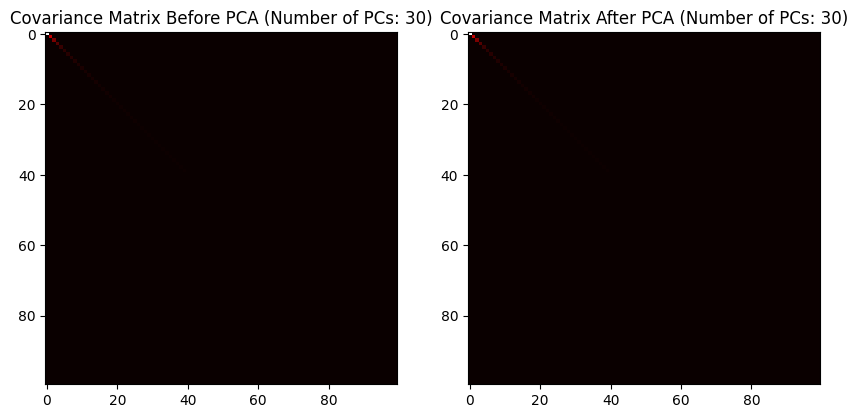

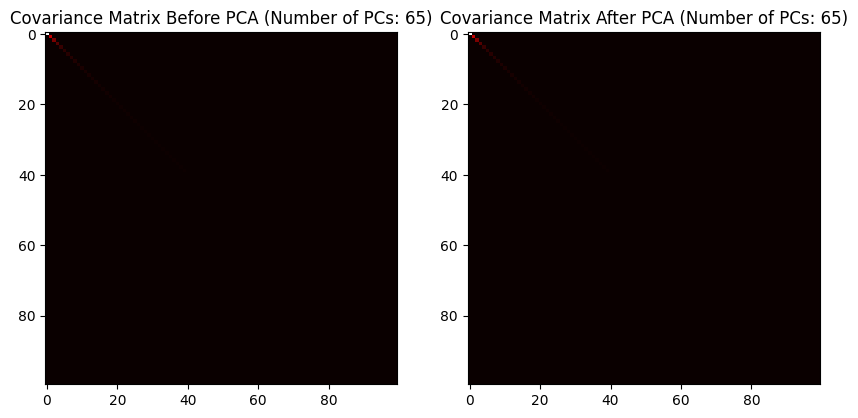

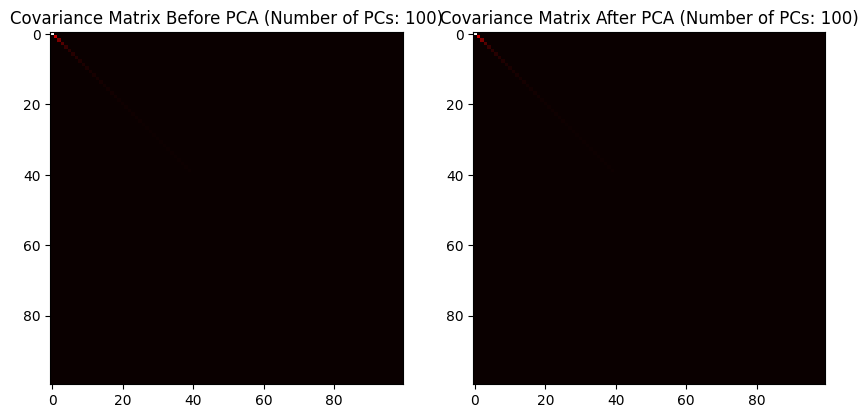

Best Accuracy Acheived>: 13.0 %
Best Computation Time Achieved>: 0.13546442985534668 sec


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import time


class FaceRecognition:
    def __init__(self, data_path):
        self.data_path = data_path
        self.data_load = None
        self.data = None
        self.data_normalization = None

    def load_data(self):  # for loading dataframe
        self.data_load = pd.read_csv(self.data_path, delimiter=',', header=None)
        self.data = self.data_load.values.astype(float)

    def Normalization_of_data(self):  # Normalizing Values Between 1 & 0 as using this data to pass on PCA & KNN
        # This operation ensures that each row (face image vector) in self.data is normalized to have unit length.
        self.data_normalization = self.data / np.linalg.norm(self.data, axis=1, keepdims=True)

    def PCA(self, data, no_of_PC):
        # PCA reduces dimensionality of the data to a specified number of principal components (no_of_PC).
        Pricipal_Comp_Analysis = PCA(n_components=max(no_of_PC))
        reduced_data = Pricipal_Comp_Analysis.fit_transform(data)
        return reduced_data, Pricipal_Comp_Analysis

    def Distance_Computation(self, reduced_train_data, test_data, distance_measure):
        distances = None

        if distance_measure == 'euclidean':
            # Signifies the shortest distance between two points (works on Pythagoras theorem)
            distances = np.linalg.norm(reduced_train_data - test_data, axis=1)

        elif distance_measure == 'mahalanobis':
            inv_cov_matrix = np.linalg.inv(np.cov(reduced_train_data.T))
            diff = reduced_train_data - test_data
            distances = np.sqrt(np.sum(np.dot(diff, inv_cov_matrix) * diff, axis=1))

        elif distance_measure == 'cosine':
            dot_products = np.dot(reduced_train_data, test_data)
            train_norms = np.linalg.norm(reduced_train_data, axis=1)
            test_norm = np.linalg.norm(test_data)
            distances = 1 - dot_products / (train_norms * test_norm)

        return distances

    def split_data(self, no_of_subjects, img_per_subj, num_of_training_samples):
        # for splitting the normalized data into training and test sets.
        num_test_samples = img_per_subj - num_of_training_samples
        train_data = []
        train_labels = []
        test_data = []
        test_labels = []

        np.random.shuffle(self.data_normalization)

        for subject in range(no_of_subjects):
            # Subject iterates over 0 to n-1, no_of_subjects is the number of images in the dataset
            subject_data = self.data_normalization[subject * img_per_subj: (subject + 1) * img_per_subj]
            np.random.shuffle(subject_data)

            train_data.extend(subject_data[:num_of_training_samples])  # Append first training samples
            train_labels.extend([subject] * num_of_training_samples)  # Create labels for training samples
            test_data.extend(subject_data[num_of_training_samples:])  # Append remaining training samples to test_data
            test_labels.extend([subject] * num_test_samples)  # Create labels for test samples

        return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)


    def Label_Predictions(self, distances, train_labels, k):
        nearest_neighbors = np.argsort(distances)[:k]
        nearest_labels = train_labels[nearest_neighbors.flatten()]
        predicted_label = np.argmax(np.bincount(nearest_labels))
        return predicted_label

    def Evaluation(self, train_data, train_labels, test_data, test_labels, measure_dist, k_selected_values,
                   no_of_PC, Principal_Comp_Analysis):
        covariance_matrices_before = []
        covariance_matrices_after = []
        accuracy_results = []
        computation_times = []

        for distance_measure in measure_dist:
            for k in k_selected_values:
                for num_pc in no_of_PC:
                    if num_pc <= train_data.shape[1]:#ensures that the number of PCs does not exceed the dimensionality of the training data.
                        reduced_train_data, _ = self.PCA(train_data, no_of_PC)
                        reduced_test_data = Principal_Comp_Analysis.transform(test_data)
                        predictions = []

                        start_time = time.time()

                        for i in range(len(reduced_test_data)):
                            test_sample = reduced_test_data[i]
                            distances = self.Distance_Computation(reduced_train_data, test_sample, distance_measure)
                            predicted_label = self.Label_Predictions(distances, train_labels, k)
                            predictions.append(predicted_label)

                        end_time = time.time()
                        computation_time = end_time - start_time

                        accuracy = accuracy_score(test_labels, predictions)
                        accuracy_results.append(accuracy)
                        computation_times.append(computation_time)

                        covariance_matrices_before.append(np.cov(train_data.T))
                        covariance_matrices_after.append(np.cov(reduced_train_data.T))

                        print(f"Measured Distances : {distance_measure}, k_value: {k}, Number of PCs: {num_pc}")
                        print("Accuracy:", accuracy)
                        print("Computation Time used:", computation_time)
                        print()

        return covariance_matrices_before, covariance_matrices_after, accuracy_results, computation_times

    def Show_covariance_matrix(self, covariance_matrices_before, covariance_matrices_after, no_of_PC):
        for i, num_pc in enumerate(no_of_PC):
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(covariance_matrices_before[i], cmap='hot', interpolation='nearest')
            axes[0].set_title(f"Covariance Matrix Before PCA (Number of PCs: {num_pc})")
            axes[1].imshow(covariance_matrices_after[i], cmap='hot', interpolation='nearest')
            axes[1].set_title(f"Covariance Matrix After PCA (Number of PCs: {num_pc})")
            plt.show()


def Execute(data_path, no_of_subjects, img_per_subj, num_of_training_samples, no_of_splits,
             measure_dist, k_selected_values, no_of_PC):
    face_recognition = FaceRecognition(data_path)
    face_recognition.load_data()
    face_recognition.Normalization_of_data()

    best_accuracy = 0.0

    train_data, train_labels, test_data, test_labels = face_recognition.split_data(no_of_subjects, img_per_subj,
                                                                                  num_of_training_samples)

    reduced_data, Principal_Comp_Analysis = face_recognition.PCA(train_data, no_of_PC)
    covariance_matrices_before, covariance_matrices_after, accuracy_results, computation_times = \
        face_recognition.Evaluation(reduced_data, train_labels, test_data, test_labels, measure_dist,
                                    k_selected_values, no_of_PC, Principal_Comp_Analysis)

    face_recognition.Show_covariance_matrix(covariance_matrices_before, covariance_matrices_after, no_of_PC)

    max_accuracy = np.max(accuracy_results) * 100
    best_accuracy = max(max_accuracy, best_accuracy)

    best_accuracy_index = np.argmax(accuracy_results)
    best_computation_time = computation_times[best_accuracy_index]

    print("Best Accuracy Acheived>:", best_accuracy, "%")
    print("Best Computation Time Achieved>:", best_computation_time, "sec")


data_path = '/content/drive/MyDrive/fea.csv'
no_of_subjects = 10
img_per_subj = 170
num_of_training_samples = 150
no_of_splits = 5
measure_dist = ['euclidean', 'mahalanobis', 'cosine']
k_selected_values = [19, 155, 199]
no_of_PC = [30, 65, 100]

Execute(data_path, no_of_subjects, img_per_subj, num_of_training_samples, no_of_splits,
         measure_dist, k_selected_values, no_of_PC)
